# Kaczmarz Relaxation - Smoothing Factor

In [30]:
%load_ext autoreload
%autoreload 2

import collections
import helmholtz as hm
import helmholtz.analysis
import helmholtz.analysis.stats
import numpy as np
import pandas as pd
import scipy.linalg
import matplotlib.pyplot as plt
from IPython.display import display

np.set_printoptions(linewidth=500, precision=2, suppress=False, threshold=100000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
kh = 0.8 ** 0.5
discretization_values = ("3-point", "5-point")
t = np.linspace(-np.pi, np.pi, 100)
kh_values = np.linspace(0, 2, 50)

def smoothing(kh, discretization):
    a = hm.analysis.lfa.a_poly(kh, discretization)
    mu = hm.analysis.lfa.kaczmarz(a, t)
    return max(mu[np.abs(t) >= 0.5 * np.pi])

mu_bar = dict(
    (discretization, np.array([smoothing(kh, discretization) for kh in kh_values]))
    for discretization in discretization_values)

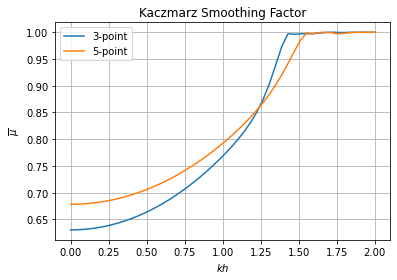

In [27]:
fig, axs = plt.subplots(1, 1, figsize = (6, 4))

ax = axs
for discretization in discretization_values:
    ax.plot(kh_values, mu_bar[discretization], label=discretization)
    ax.legend(loc="upper left")
    ax.set_xlabel(r"$kh$")
    ax.set_ylabel(r"$\overline{\mu}$")
ax.grid(True);
ax.set_title("Kaczmarz Smoothing Factor");

Smoothing is good up to the transition region ($kh \geq 0.7$), which is expected, given that the characteristic components start becoming high frequencies there.

Generally, smoothing is harder to acehive for the high-order discretization.

## Smoothing vs. Mock Cycle Rates for 2/1 Coarsening

In [64]:
n = 96
nu_values = np.arange(1, 9)
r_values = [
    ("SVD", None),
    ("Injection", [[1, 0]]),
    ("[1, 1]", [[1, 1]]),
    ("[1, -1]", [[1, -1]]),
]
coarsening_info_21 = dict(
    ((discretization, r_label),
     pd.DataFrame([hm.analysis.stats.mock_cycle_rate(
         hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n), 2, 1, 
         nu_values=nu_values, r=None if r is None else np.array(r))
                   for kh in kh_values], 
                  index=kh_values, columns=("Shrinkage", "#sweeps") + tuple(nu_values))
    ) for discretization in discretization_values for r_label, r in r_values)

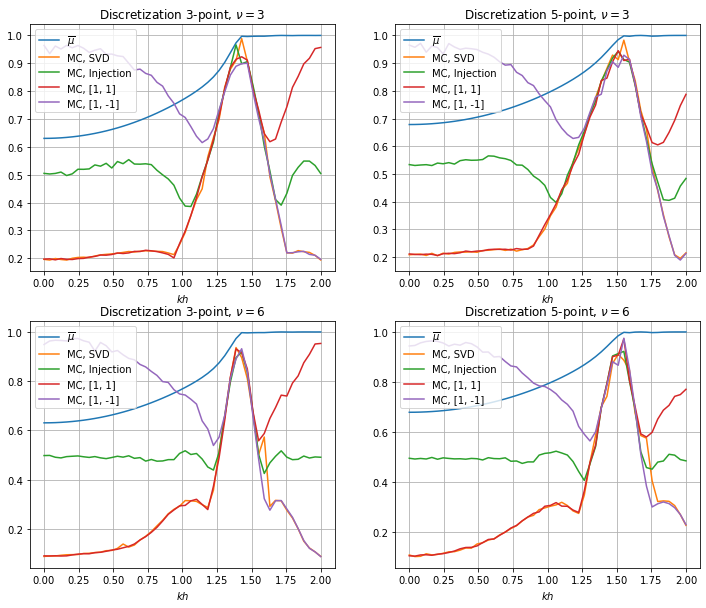

In [69]:
nu_values = (3, 6)
fig, axs = plt.subplots(len(nu_values), 2, figsize = (12, 5 * len(nu_values)))

for row, nu in enumerate(nu_values):
    for col, discretization in enumerate(discretization_values):
        ax = axs[row, col]
        ax.plot(kh_values, mu_bar[discretization], label="$\\overline{\mu}$")
        for r_label, _ in r_values:
            ax.plot(kh_values, coarsening_info_21[(discretization, r_label)][[nu]], 
                    label="MC, {}".format(r_label))
        ax.legend(loc="upper left")
        ax.set_xlabel(r"$kh$")
        ax.set_title("Discretization {}, $\\nu = {}$".format(discretization, nu))
        ax.grid(True);

Notation:
* $\overline{\mu}$ = Kaczmarz smoothing factor.
* MC = mock cycle convergence factor with $\nu$ relaxations per cycle, per unit relaxation sweep, i.e. $\mu_{MC(\nu)}$.
* SVD uses relaxed vectors.

Observations:
* $[1, 1]$ is good for $kh \leq 1$.
* $[1, -1]$ is good for $kh \geq 1.75$.
* Injection is margnically OK for all values of $kh$. But it works except for the transition region [1, 1.75], with convergence factor of 0.5.
* The SVD $R$ is the optimal choice - it automatically picks $[1, 1]$ or $[1, -1]$ in the different regions.
* So, 2/1 coarsening works, except for the transition region [1, 1.75].

## Smoothing vs. Mock Cycle Rates for 4/2 Coarsening

In [70]:
n = 96
nu_values = np.arange(1, 9)
r_values = [
    ("SVD", None),
]
coarsening_info_42 = dict(
    ((discretization, r_label),
     pd.DataFrame([hm.analysis.stats.mock_cycle_rate(
         hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n), 4, 2, 
         nu_values=nu_values, r=None if r is None else np.array(r))
                   for kh in kh_values], 
                  index=kh_values, columns=("Shrinkage", "#sweeps") + tuple(nu_values))
    ) for discretization in discretization_values for r_label, r in r_values)

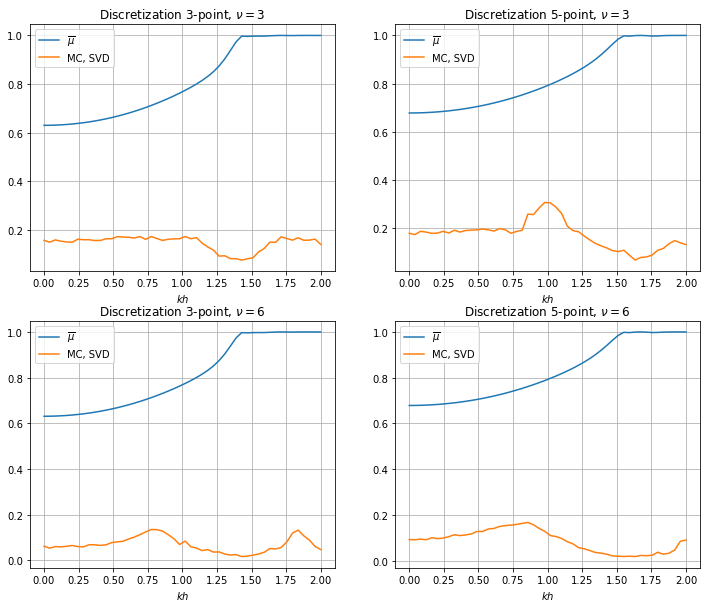

In [74]:
nu_values = (3, 6)
fig, axs = plt.subplots(len(nu_values), 2, figsize = (12, 5 * len(nu_values)))

for row, nu in enumerate(nu_values):
    for col, discretization in enumerate(discretization_values):
        ax = axs[row, col]
        ax.plot(kh_values, mu_bar[discretization], label="$\\overline{\mu}$")
        for r_label, _ in r_values:
            ax.plot(kh_values, coarsening_info_42[(discretization, r_label)][[nu]], 
                    label="MC, {}".format(r_label))
        ax.legend(loc="upper left")
        ax.set_xlabel(r"$kh$")
        ax.set_title("Discretization {}, $\\nu = {}$".format(discretization, nu))
        ax.grid(True);

4/2 works for all $kh$ values.

## Conclusion - 2/1 Coarsening
If Kaczmarz has inadequate smoothing for $kh > 1$ and inadequate flip-smoothing (smoothing of $(-1)^j u_j$) for $kh < 1.7$, then, formally, every $kh$ such that $1 < 2^l k h < 1.7$ for some positive integer $l$ will have inadequate smoothing at some level $l$.

So only some lucky $15\%$ of all $kh. < 1$ would work well with 2/1 coarsening at all levels.